In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.decomposition import PCA
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import confusion_matrix, accuracy_score, precision_score, recall_score, ConfusionMatrixDisplay
from sklearn.ensemble import HistGradientBoostingClassifier

plt.style.use('fivethirtyeight')

In [2]:
features_target_train = pd.read_csv("data/features_target_train.csv")
features_target_test = pd.read_csv("data/features_target_test.csv")

In [3]:
columns = features_target_train.columns

In [4]:
X_train = features_target_train[columns[:-1]]
X_test = features_target_test[columns[:-1]]

y_train = features_target_train[columns[-1]]
y_test = features_target_test[columns[-1]]

# Check for zero variance columns

In [5]:
col_to_del = []
for column, variance in X_train.var().items():
    if variance == 0:
        print(column, variance)
        col_to_del.append(column)

SMR_VSA8 0.0
SlogP_VSA9 0.0
fr_diazo 0.0
fr_prisulfonamd 0.0


Remove zero variance columns from X_train and X_test

In [6]:
X_train = X_train.drop(columns=col_to_del)
X_test = X_test.drop(columns=col_to_del)

# PCA
I will apply a 95% PCA

In [7]:
scaler = StandardScaler()
X_train_std = scaler.fit_transform(X_train)
X_test_std = scaler.transform(X_test)

pca = PCA(0.95)
X_train_pca = pca.fit_transform(X_train_std)
X_test_pca = pca.transform(X_test_std)

In [8]:
print(f"Number of components: {pca.n_components_}")

Number of components: 87


# Train and test

In [9]:
lr = LogisticRegression(class_weight="balanced")
lr.fit(X_train_pca, y_train)

LogisticRegression(class_weight='balanced')

In [10]:
predictions = lr.predict(X_test_pca)
print(f"Accuracy score: {accuracy_score(y_test, predictions) * 100:.2f}%")

Accuracy score: 57.77%


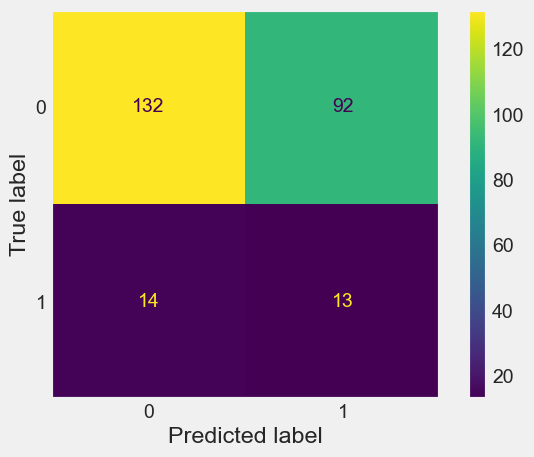

In [11]:
fig, ax = plt.subplots()    

disp = ConfusionMatrixDisplay(confusion_matrix=confusion_matrix(y_test, predictions))
disp.plot(ax=ax)
ax.grid()
plt.show()

In [12]:
gradient_boosting = HistGradientBoostingClassifier(class_weight="balanced")
gradient_boosting.fit(X_train_pca, y_train)

HistGradientBoostingClassifier(class_weight='balanced')

In [13]:
predictions = gradient_boosting.predict(X_test_pca)
print(f"Accuracy score: {accuracy_score(y_test, predictions) * 100:.2f}%")

Accuracy score: 83.67%


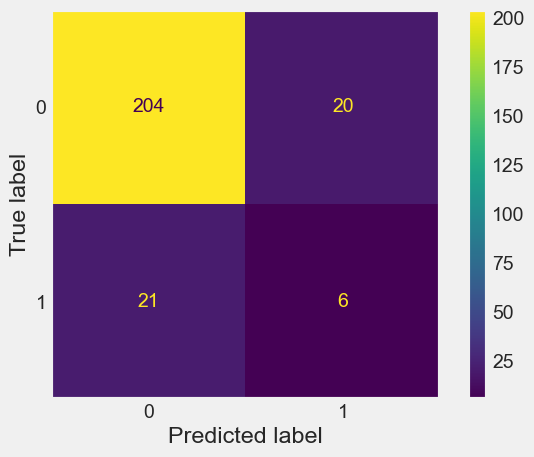

In [14]:
fig, ax = plt.subplots()    

disp = ConfusionMatrixDisplay(confusion_matrix=confusion_matrix(y_test, predictions))
disp.plot(ax=ax)
ax.grid()
plt.show()